# Implementation of RMSprop Optimizer on Fashion MNIST model

In [1]:
from fashionmnist_model import FMM
import tensorflow as tf
from sklearn.model_selection import KFold

In [2]:
# Load and preprocess the data
X_train, y_train, X_test, y_test = FMM.load_data()

In [3]:
# Reshape the data
X_train, X_test = FMM.reshape_data(X_train, X_test)

In [4]:
optimizer = tf.keras.optimizers.RMSprop()
model = FMM.get_model()
print(f"Training with {optimizer.__class__.__name__} optimizer...")
history = FMM.compile_and_train(
    model, X_train, y_train, optimizer
)

Training with model model_v1 ...
Training with RMSprop optimizer...
Epoch 1/30


2024-02-23 21:54:18.231783: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


750/750 [==============================] - 1s 1ms/step - loss: 0.5336 - accuracy: 0.8076 - val_loss: 0.4250 - val_accuracy: 0.8495
Epoch 2/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3811 - accuracy: 0.8605 - val_loss: 0.3644 - val_accuracy: 0.8705
Epoch 3/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3429 - accuracy: 0.8734 - val_loss: 0.3618 - val_accuracy: 0.8698
Epoch 4/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3219 - accuracy: 0.8822 - val_loss: 0.3488 - val_accuracy: 0.8788
Epoch 5/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3047 - accuracy: 0.8874 - val_loss: 0.3565 - val_accuracy: 0.8804
Epoch 6/30
750/750 [==============================] - 1s 1ms/step - loss: 0.2921 - accuracy: 0.8927 - val_loss: 0.3501 - val_accuracy: 0.8825
Epoch 7/30
750/750 [==============================] - 1s 1ms/step - loss: 0.2799 - accuracy: 0.8982 - val_loss: 0.3577 - val_accuracy: 0.8806
Epoch 8/30
750/75

313/313 - 0s - loss: 0.6261 - accuracy: 0.8842 - 136ms/epoch - 435us/step

Training accuracy : 0.934416651725769
Validation accuracy : 0.8885833621025085
Loss : 0.6260644197463989
Accuracy : 0.8841999769210815



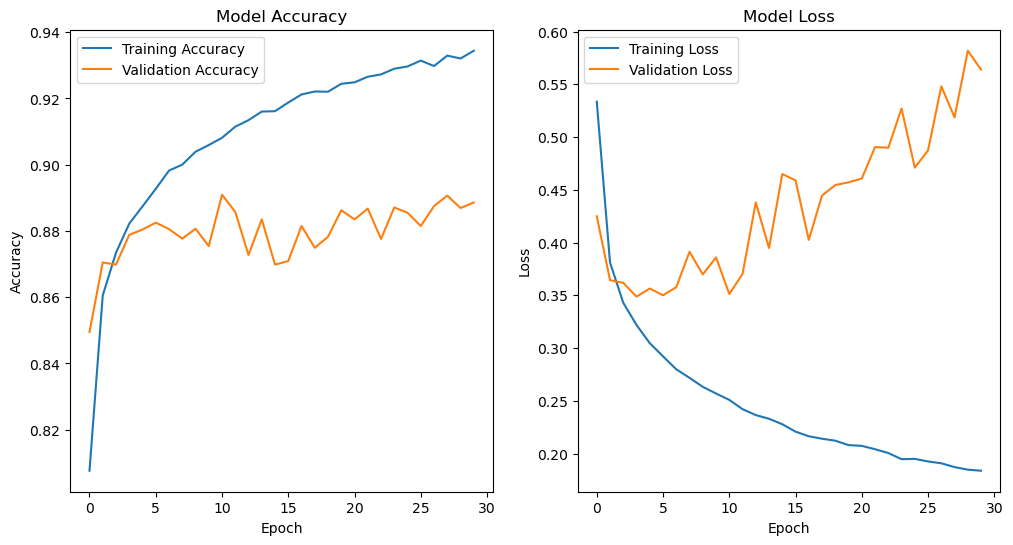

In [5]:
FMM.evaluate(model, X_test, y_test, history)
FMM.plot_history(history)

The trend shows that the training loss is increasing over time, while the validation loss is decreasing. This suggests that the model is overfitting the training data.

# Hyperparameter tunning

In [6]:
import ray
from ray import tune, train

# ! pip install -U "ray[data,train,tune,serve]"

In [7]:
ray.init()

2024-02-23 21:54:51,104	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.5
Ray version:,2.9.2
Dashboard:,http://127.0.0.1:8265


In [8]:
# Define a function to train the model
def train_model(config, kf):
    from fashionmnist_model import FMM
    import tensorflow as tf
    import ray

    
    X_train, y_train, X_test, y_test = FMM.load_data()
    X_train, X_test = FMM.reshape_data(X_train, X_test)
    
    # Extract k-fold splits
    for train_index, val_index in kf.split(X_train):
        x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Define and compile the model
        model = FMM.get_model()
        optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=config["learning_rate"]
        )
        model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train the model
        history = model.fit(x_train_fold, y_train_fold,
                            validation_data=(x_val_fold, y_val_fold),
                            epochs=40, batch_size=64, verbose=0)
        
        # Evaluate the model
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        
        # Report results
        train.report({"accuracy": accuracy, "loss":loss, "learning_rate":config["learning_rate"]})


In [9]:
search_space = {
    "learning_rate": tune.grid_search([0.001, 0.0005, 0.0001]),
    # "rho": tune.grid_search([0.9, 0.95, 0.99]),
    # "epsilon": tune.grid_search([1e-8, 1e-7, 1e-6]),
    # "weight_decay": tune.grid_search([1e-6, 1e-5, 1e-4]),
}

In [10]:
from sklearn.model_selection import KFold
#Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True)


In [11]:
# Run hyperparameter tuning 
analysis = tune.run(
    lambda config: train_model(config, kf),
    config=search_space,
    metric="accuracy",
    mode="max",
)

2024-02-23 21:54:51,646	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(<lambda> pid=75079) Training with model model_v1 ...


(<lambda> pid=75079) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.RMSprop` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.RMSprop`.
(<lambda> pid=75079) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.RMSprop`.
(<lambda> pid=75079) 2024-02-23 21:54:59.479025: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
(raylet) [2024-02-23 21:55:01,087 E 75063 1088269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_21-54-49_075773_75026 is over 95% full, available space: 9782644736; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=75080) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.RMSprop` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, locate

Trial name,accuracy,learning_rate,loss
lambda_149e0_00000,0.8807,0.001,0.829662
lambda_149e0_00001,0.8847,0.0005,0.533338
lambda_149e0_00002,0.8877,0.0001,0.334796


(<lambda> pid=75080) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.RMSprop` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.RMSprop`.
(<lambda> pid=75080) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.RMSprop`.


(<lambda> pid=75080) Training with model model_v1 ... [repeated 3x across cluster]


(raylet) [2024-02-23 21:56:21,675 E 75063 1088269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_21-54-49_075773_75026 is over 95% full, available space: 9744850944; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=75081) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.RMSprop` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.RMSprop`. [repeated 2x across cluster]
(<lambda> pid=75081) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.RMSprop`. [repeated 2x across cluster]
(raylet) [2024-02-23 21:56:31,679 E 75063 1088269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_21-54-49_075773_75026 is over 95% full, available space: 9737871360; capacity: 245107195904. Object creation will fail if spilling is required.
(r

(<lambda> pid=75080) Training with model model_v1 ... [repeated 3x across cluster]


(raylet) [2024-02-23 21:57:51,887 E 75063 1088269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_21-54-49_075773_75026 is over 95% full, available space: 9735012352; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=75081) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.RMSprop` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.RMSprop`. [repeated 2x across cluster]
(<lambda> pid=75081) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.RMSprop`. [repeated 2x across cluster]
(raylet) [2024-02-23 21:58:01,984 E 75063 1088269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_21-54-49_075773_75026 is over 95% full, available space: 9734803456; capacity: 245107195904. Object creation will fail if spilling is required.
(r

(<lambda> pid=75080) Training with model model_v1 ... [repeated 3x across cluster]


(raylet) [2024-02-23 21:59:12,385 E 75063 1088269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_21-54-49_075773_75026 is over 95% full, available space: 9741033472; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=75081) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.RMSprop` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.RMSprop`. [repeated 2x across cluster]
(<lambda> pid=75081) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.RMSprop`. [repeated 2x across cluster]
(raylet) [2024-02-23 21:59:22,476 E 75063 1088269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_21-54-49_075773_75026 is over 95% full, available space: 9740980224; capacity: 245107195904. Object creation will fail if spilling is required.
(r

(<lambda> pid=75080) Training with model model_v1 ... [repeated 3x across cluster]


(<lambda> pid=75080) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.RMSprop` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.RMSprop`.
(<lambda> pid=75080) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.RMSprop`.
(raylet) [2024-02-23 22:00:32,965 E 75063 1088269] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_21-54-49_075773_75026 is over 95% full, available space: 9738653696; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=75081) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.RMSprop` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.RMSprop`. [repeated 2x across cluster]
(<lambda> pid=75081) WARNING:absl:There is a known slowdown when usin

In [12]:
ray.shutdown()

In [13]:
# FMM.plot_analysis_results(analysis, x_axis="learning_rate", y_axis="accuracy")

In [14]:
# Print the best hyperparameters and results
best_config = analysis.best_config
print("Best hyperparameters:", best_config)
print("Best accuracy:", analysis.best_result["accuracy"])

Best hyperparameters: {'learning_rate': 0.0001}
Best accuracy: 0.8877000212669373


In [15]:
optimizer = tf.keras.optimizers.RMSprop(**best_config)
model = FMM.get_model()
print(f"Training with {optimizer.__class__.__name__} optimizer...")
history = FMM.compile_and_train(
    model, X_train, y_train, optimizer
)

Training with model model_v1 ...
Training with RMSprop optimizer...
Epoch 1/30
750/750 [==============================] - 1s 2ms/step - loss: 0.7294 - accuracy: 0.7704 - val_loss: 0.5001 - val_accuracy: 0.8316
Epoch 2/30
750/750 [==============================] - 1s 1ms/step - loss: 0.4678 - accuracy: 0.8406 - val_loss: 0.4596 - val_accuracy: 0.8401
Epoch 3/30
750/750 [==============================] - 1s 1ms/step - loss: 0.4204 - accuracy: 0.8551 - val_loss: 0.4095 - val_accuracy: 0.8587
Epoch 4/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3943 - accuracy: 0.8620 - val_loss: 0.4057 - val_accuracy: 0.8592
Epoch 5/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3746 - accuracy: 0.8684 - val_loss: 0.3818 - val_accuracy: 0.8632
Epoch 6/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3597 - accuracy: 0.8728 - val_loss: 0.3709 - val_accuracy: 0.8701
Epoch 7/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3466

313/313 - 0s - loss: 0.3358 - accuracy: 0.8827 - 144ms/epoch - 460us/step

Training accuracy : 0.922124981880188
Validation accuracy : 0.8924999833106995
Loss : 0.33582812547683716
Accuracy : 0.8827000260353088



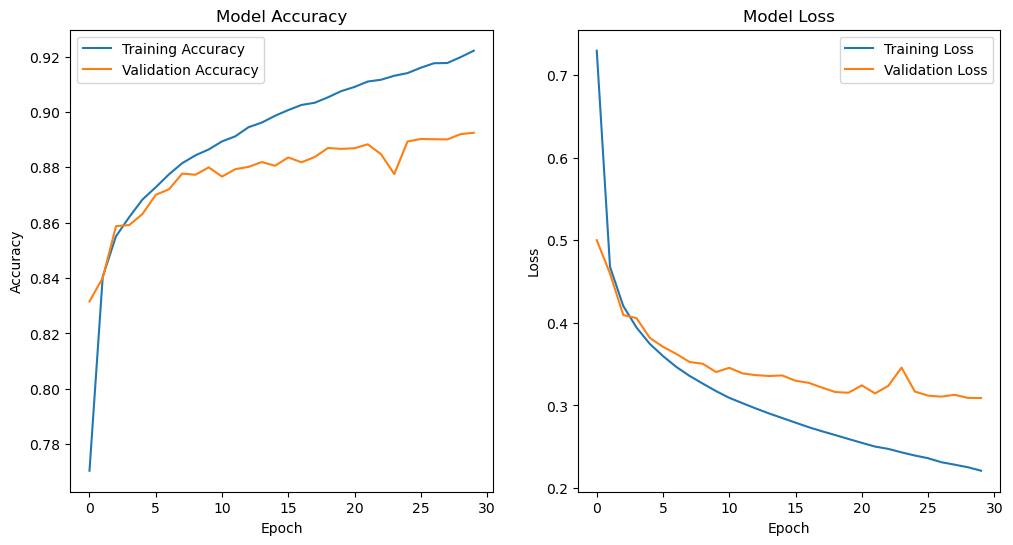

In [16]:
FMM.evaluate(model, X_test, y_test, history)
FMM.plot_history(history)